In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import VR_Model, optimize_lags
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer
from backtesting import PortfolioBacktester

In [2]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
gray_a = ['BAC', 'TSM', 'MSTR', 'VZ', 'LUMN']
green_a = ['LRCX', 'TSLA', 'NEE', 'BEP']
assets = gray_a + green_a
benchmark = '^GSPC'
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
e_eco_data = pd.merge(economic_data, climate_data, on='Date').iloc[:-1]

gray_data = all_data[gray_a]  
green_data = all_data[green_a]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


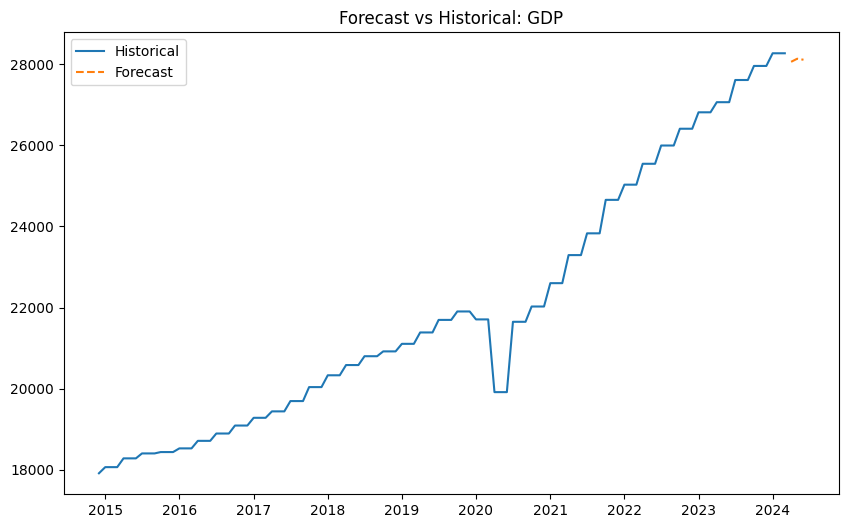

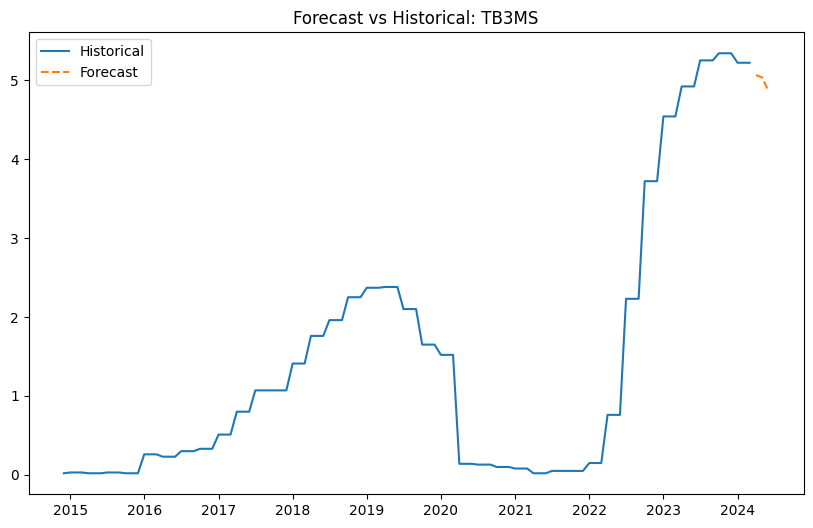

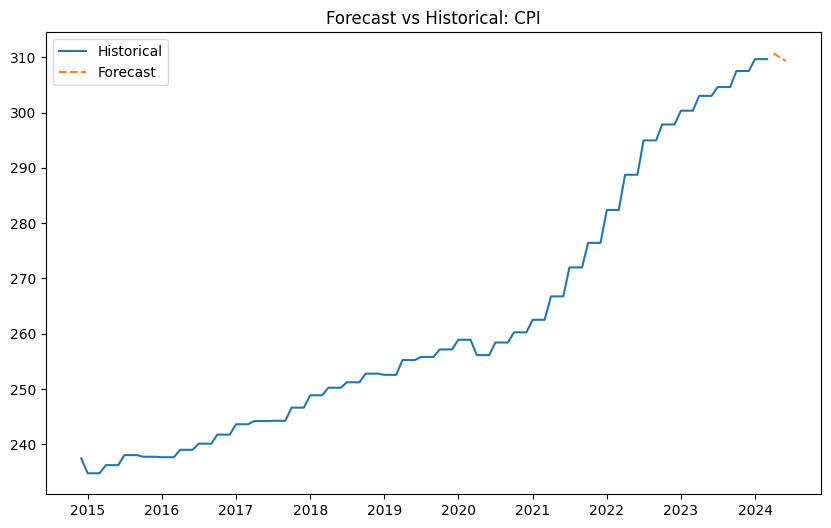

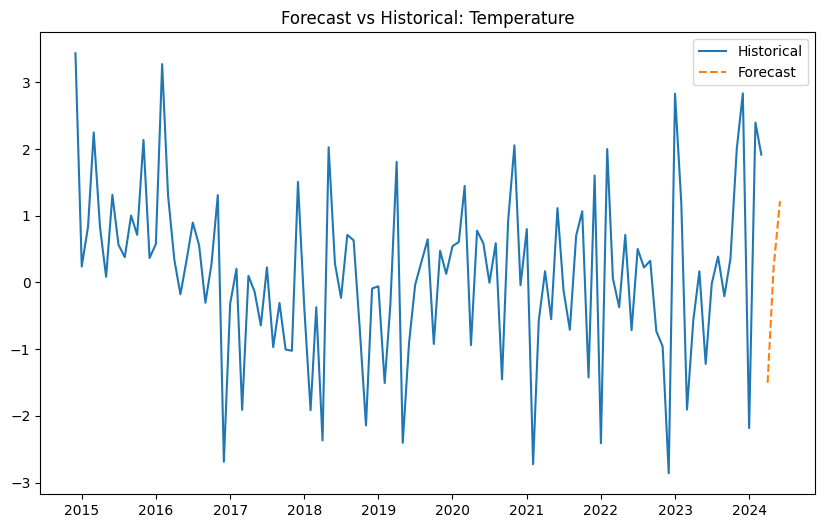

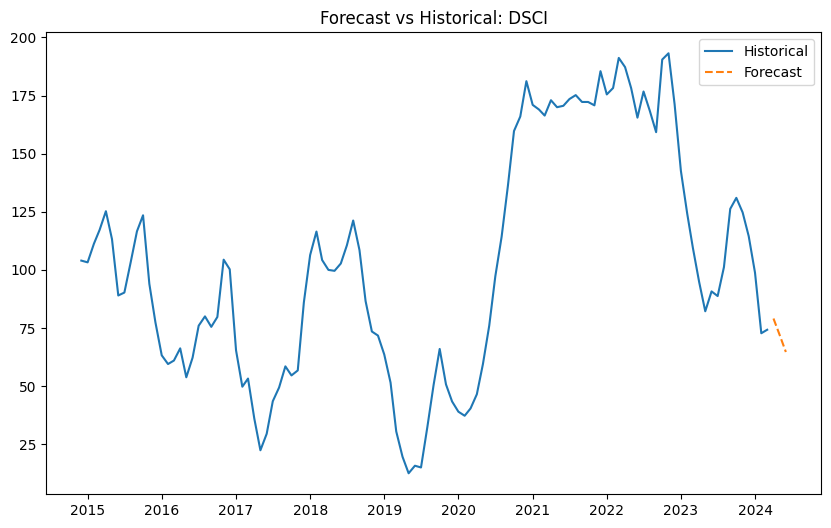

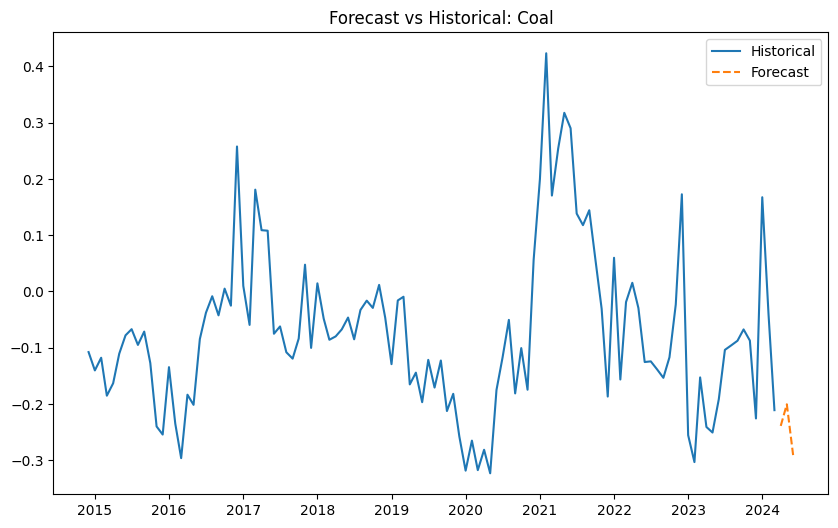

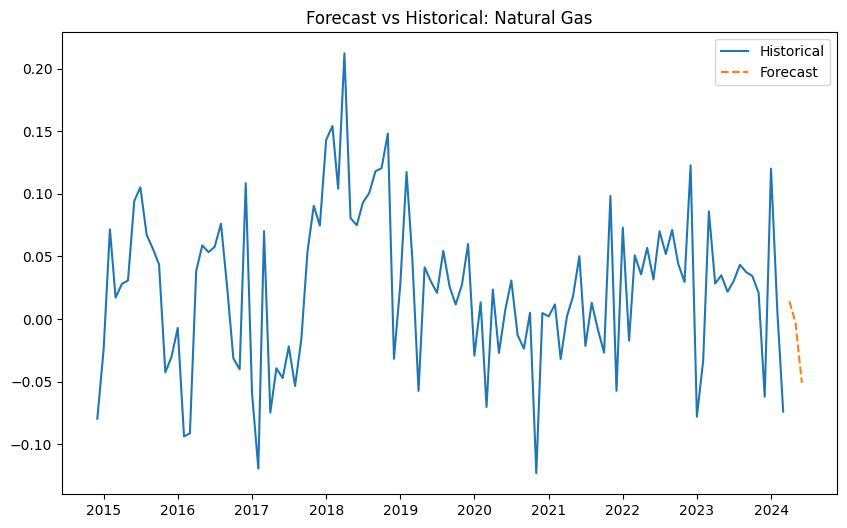

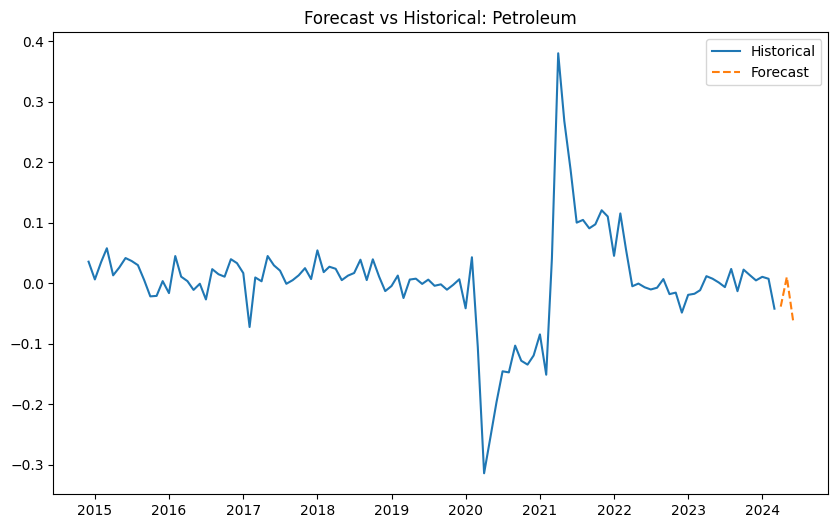

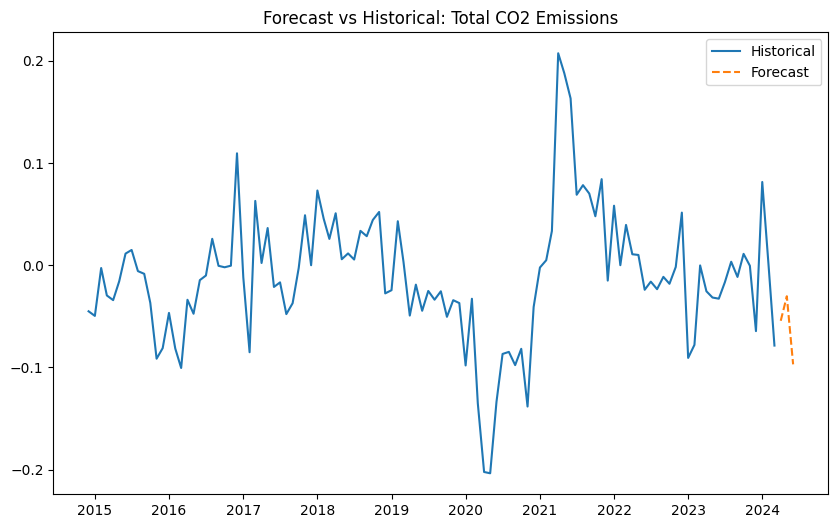

In [3]:
# Inicializar modelo
optimal_lags = optimize_lags(e_eco_data, trials=50)
vr_model = VR_Model(e_eco_data, optimal_lags)

# Ajustar el modelo y realizar predicciones
vr_model.fit()
vr_model.plot_predictions(steps=3)

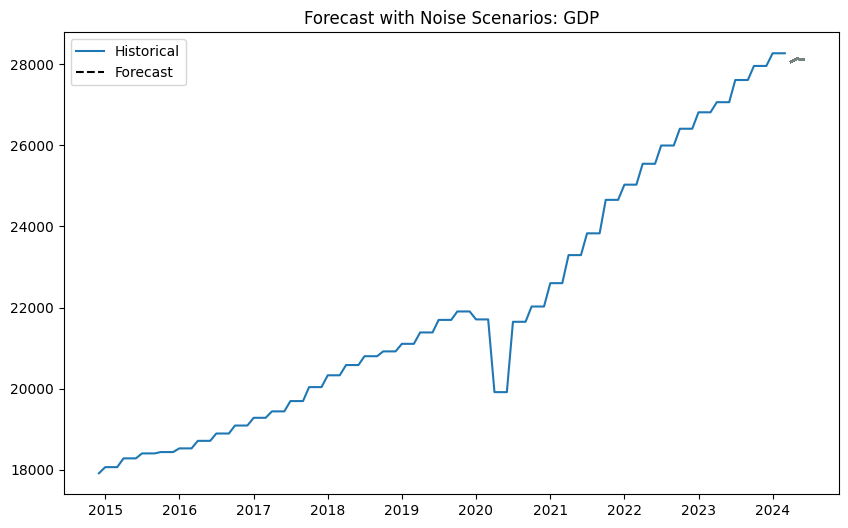

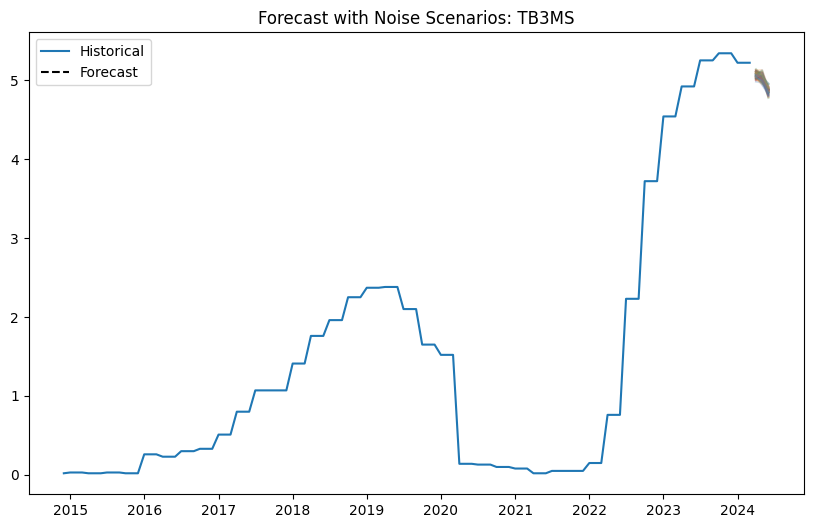

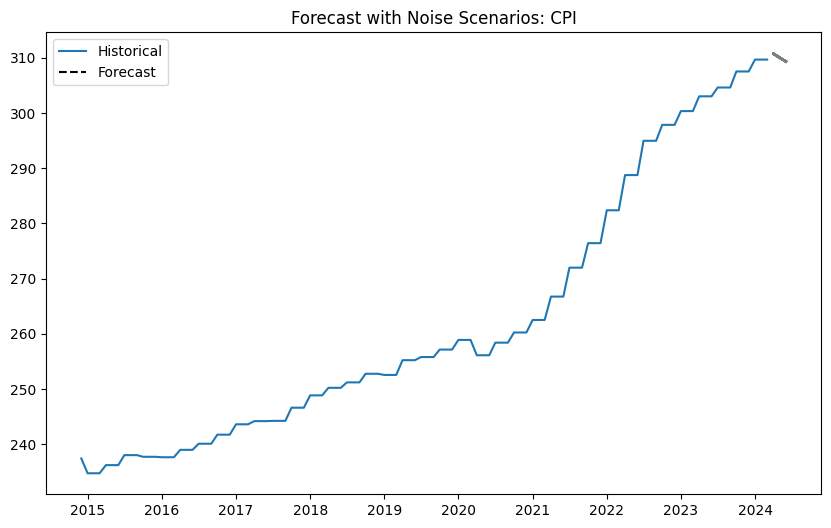

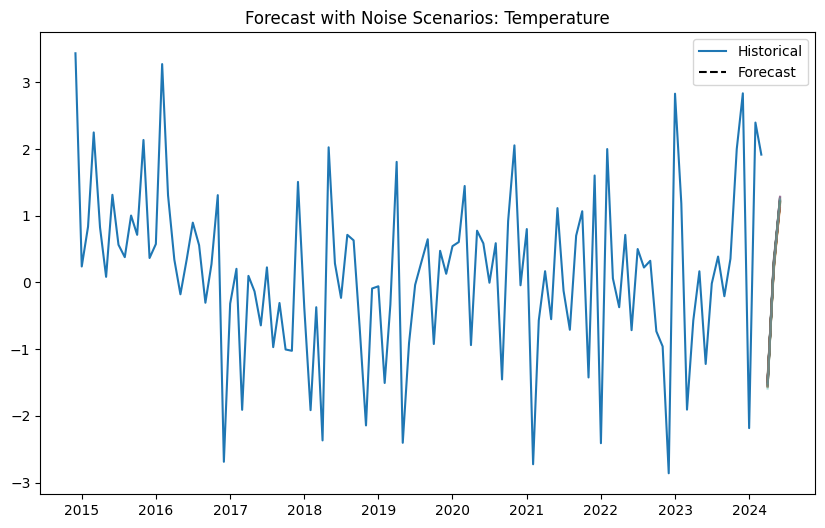

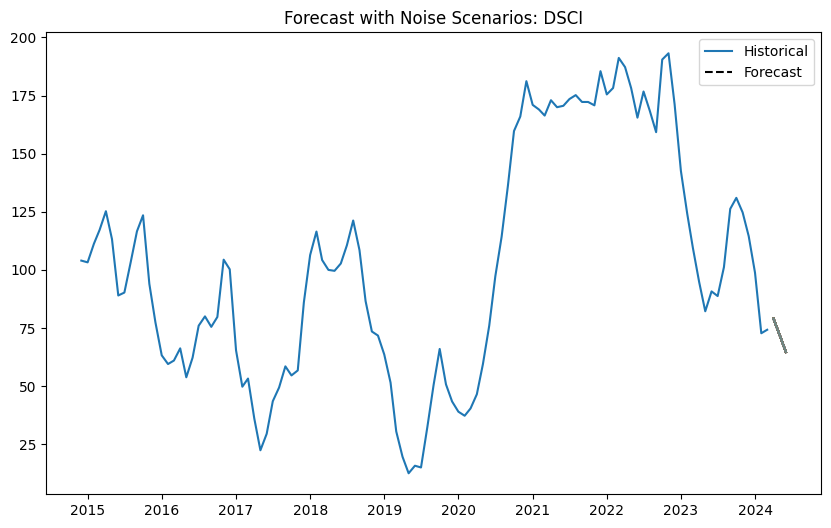

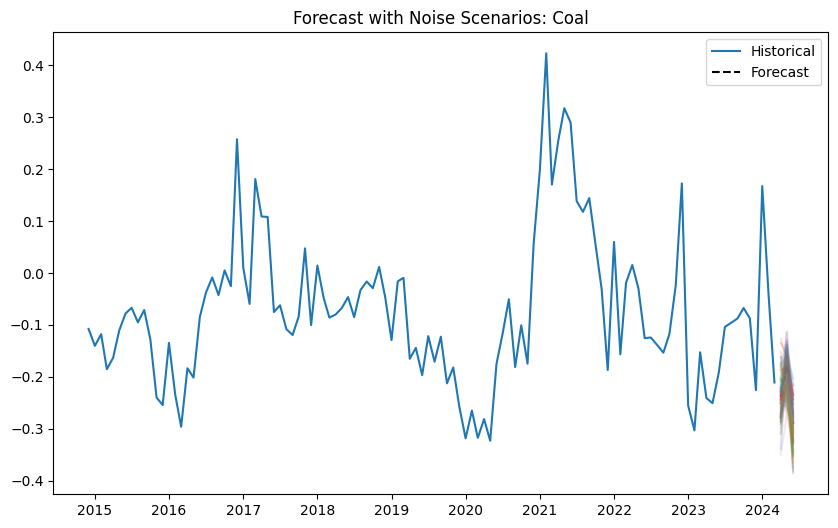

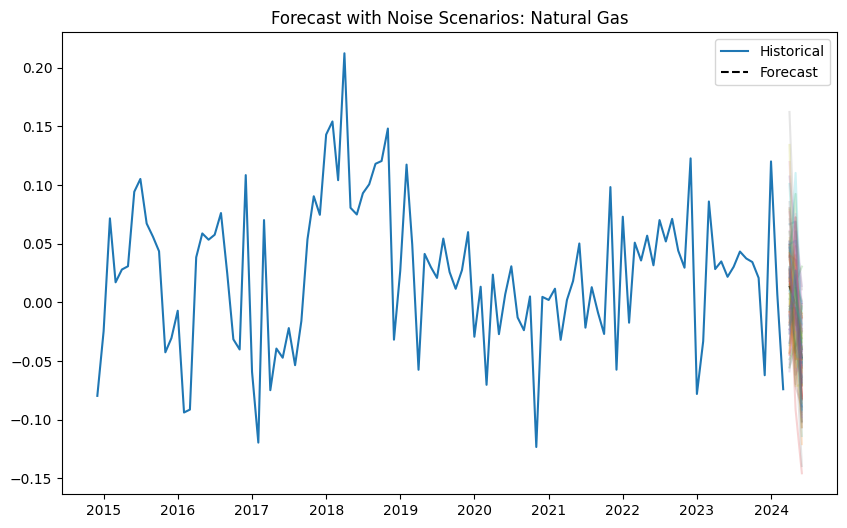

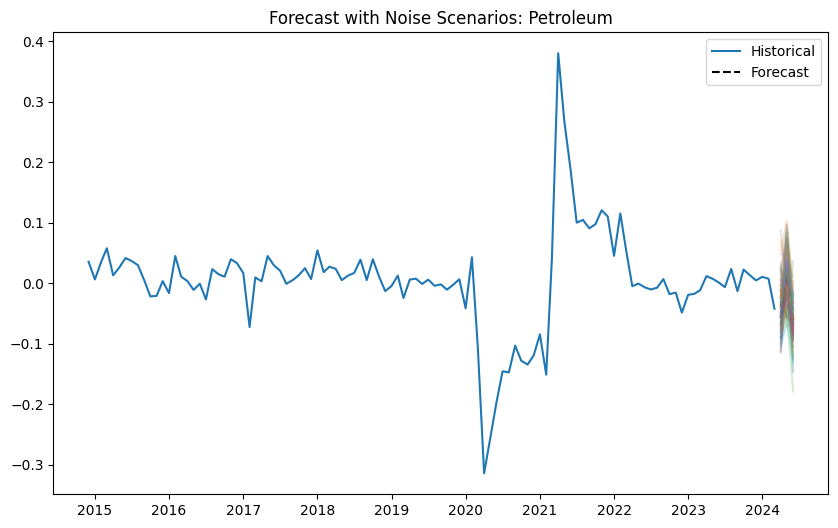

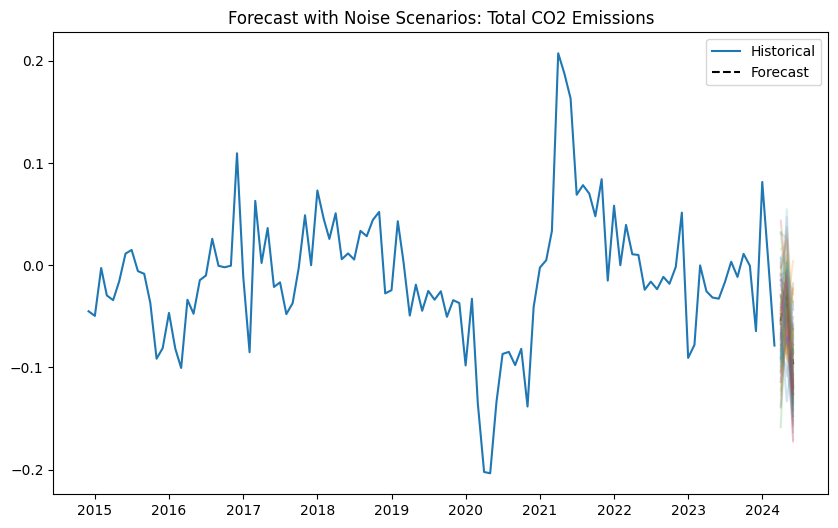

In [4]:
# Generar y graficar los escenarios con ruido
vr_model.generate_scenarios_with_noise(steps=3, n_scenarios=100)

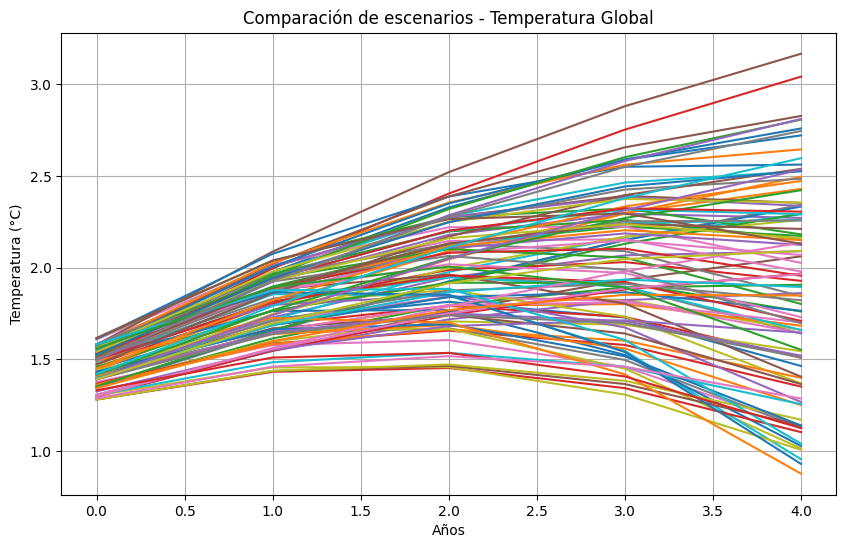

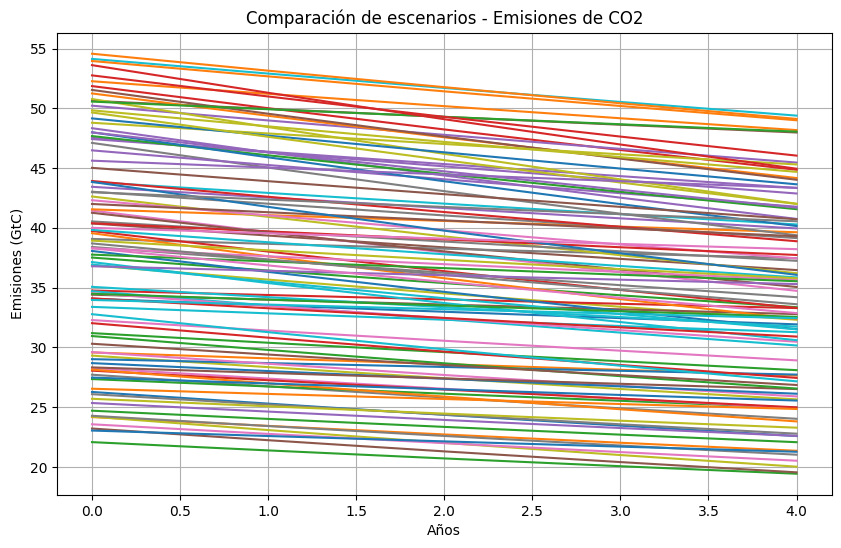

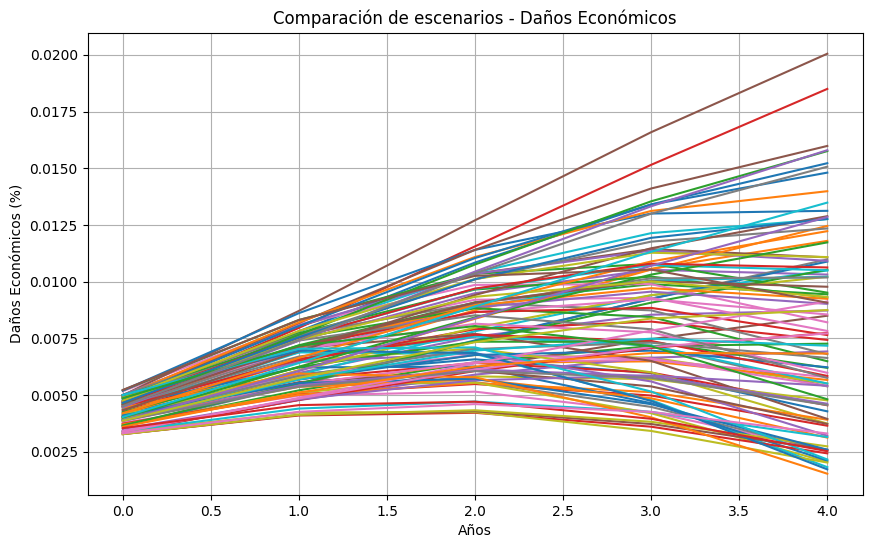

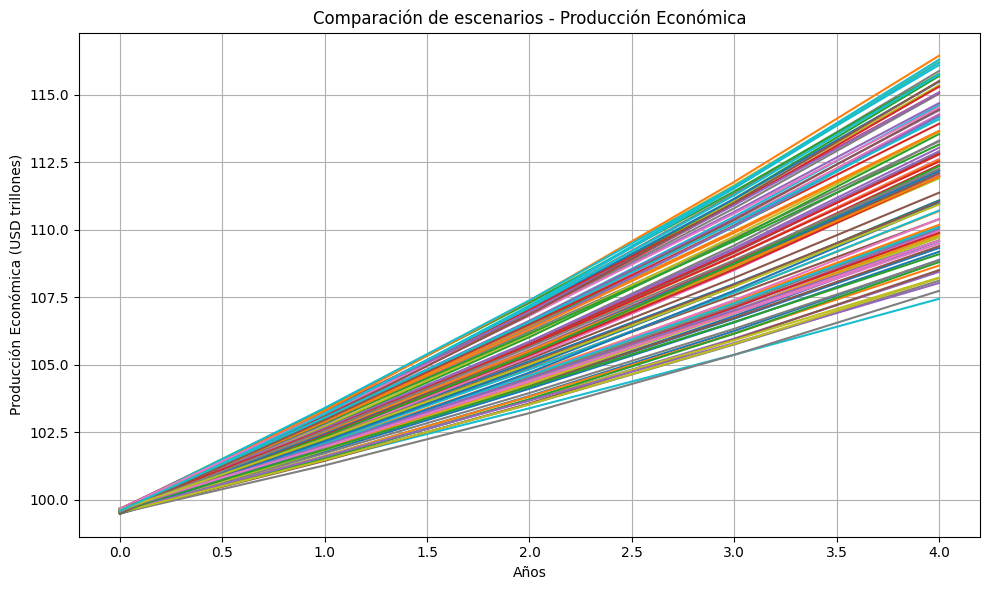

In [5]:
# Instanciar la clase ScenarioDICE
scenario_dice = ScenarioDICE()

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

In [6]:
economic_climate_vars = ['Temperature', 'DSCI', 'Coal', 'Natural Gas', 'Petroleum',
                         'Total CO2 Emissions', 'GDP', 'TB3MS', 'CPI']

aligned_data = all_data[economic_climate_vars].dropna()

aligned_data = aligned_data.loc[all_data.index]

# Inicializa un dataframe para almacenar las betas
betas_df = pd.DataFrame(index=gray_a + green_a, columns=economic_climate_vars)

# Calcula las betas de cada activo respecto a las demás variables
for asset in gray_a + green_a:
    # Prepara las variables dependientes e independientes
    X = aligned_data.values  # Variables económicas y climáticas
    y = all_data[asset].values  # Retornos del activo (ya están en all_data)

    # Ajusta un modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)

    # Almacena las betas en el dataframe
    betas_df.loc[asset] = model.coef_

betas_df

Temperature      DSCI      Coal Natural Gas Petroleum  \
BAC     0.007719  0.000412  0.177512   -0.187771 -0.121555   
TSM     0.013837  0.000023  0.015289    -0.23702 -0.555881   
MSTR     0.07797    0.0006    0.0757   -0.620289 -1.470728   
VZ     -0.001861  0.000054  0.226328    0.300992  0.315679   
LUMN    0.032623 -0.000235  0.506786    0.611691  0.375854   
LRCX    0.003001   0.00005  0.061887   -0.342654 -0.244734   
TSLA    0.025597 -0.000595 -0.850727    -0.97392 -2.026972   
NEE     0.000178 -0.000103 -0.299851   -0.380283  -0.54467   
BEP     0.003069  -0.00008 -0.290105   -0.409746  -0.62459   

     Total CO2 Emissions       GDP     TB3MS       CPI  
BAC            -0.151756  0.000012  0.020026 -0.003168  
TSM             0.423527   0.00003  0.011825 -0.004672  
MSTR            1.180027  0.000092  0.049602 -0.013483  
VZ             -0.919488  0.000017  0.010143 -0.002814  
LUMN           -1.543364  0.000061 -0.008632 -0.007826  
LRCX            0.023365  0.000022  0.017168 -0.003719  
TSLA            3.391758  0.000042 -0.044556 -0.003488  
NEE             1.139701  0.000023  -0.00609  -0.00316  
BEP             0.973067   0.00004 -0.004831 -0.005496

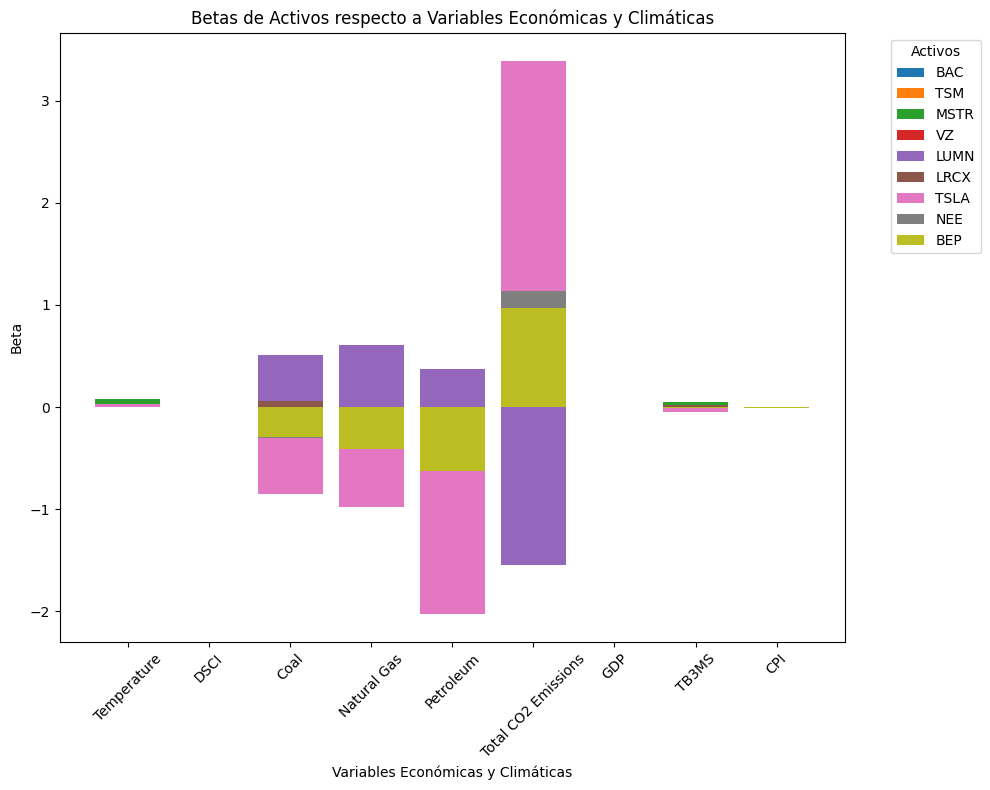

In [7]:
# Creamos una figura y subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Para cada activo, graficamos las betas respecto a las variables
for asset in betas_df.index:
    ax.bar(betas_df.columns, betas_df.loc[asset], label=asset)

# Etiquetas y títulos
ax.set_title('Betas de Activos respecto a Variables Económicas y Climáticas')
ax.set_xlabel('Variables Económicas y Climáticas')
ax.set_ylabel('Beta')
ax.legend(title="Activos", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotar etiquetas del eje x para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

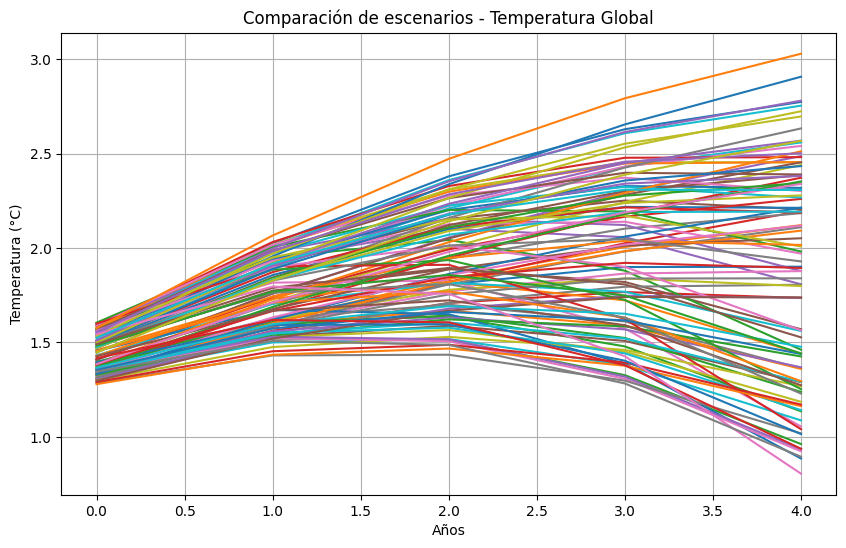

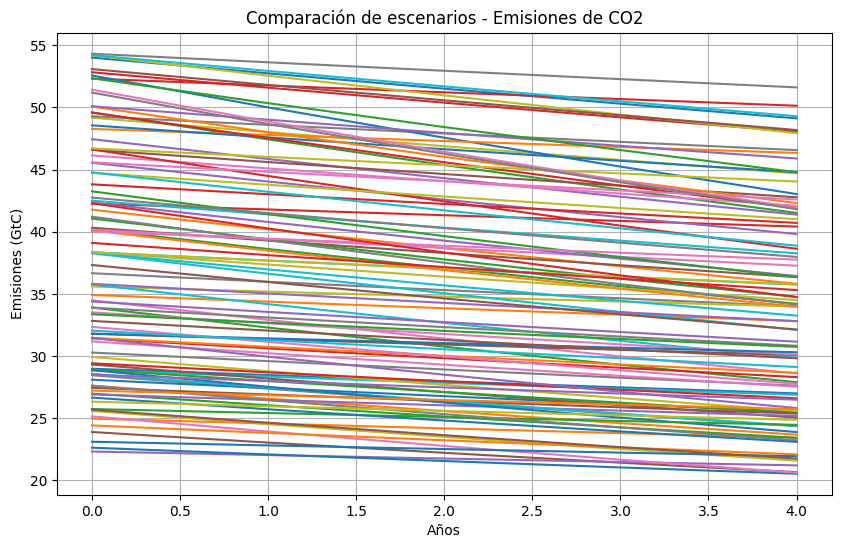

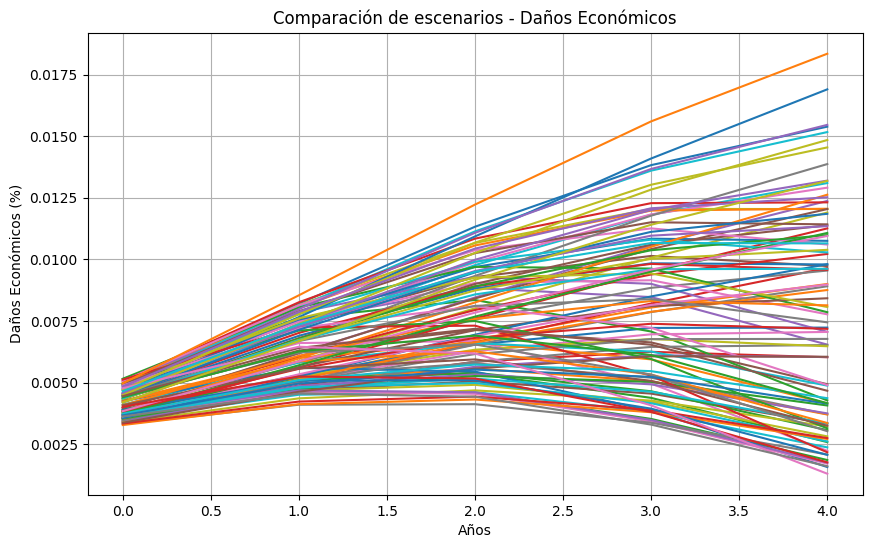

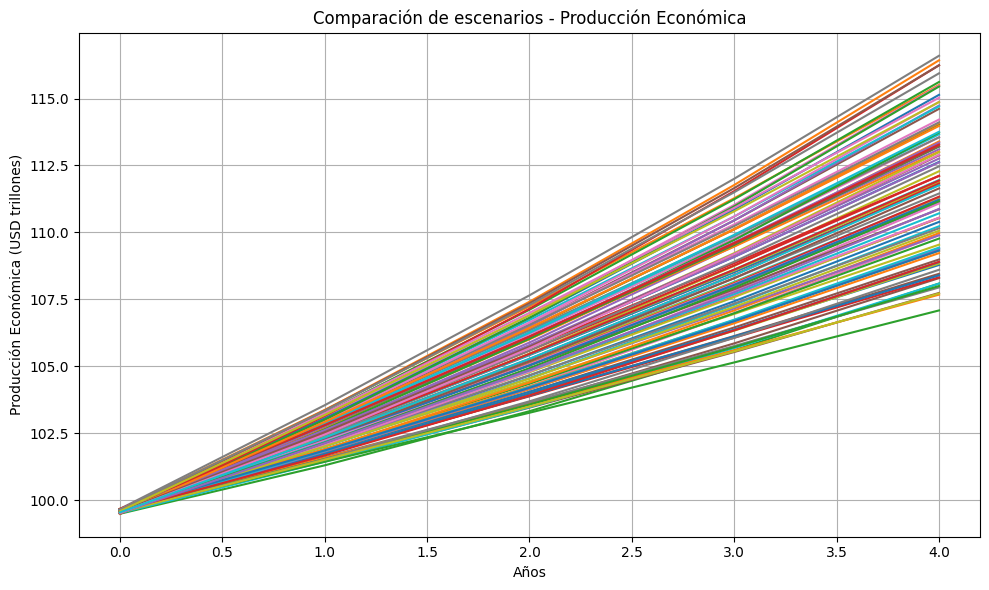


Retorno promedio del mejor portafolio: 1208.2992


In [8]:
# Definir las variables económicas y climáticas
economic_factors = economic_data[['GDP', 'TB3MS', 'CPI']]  # Selecciona las columnas económicas que te interesan
climate_factors = climate_data[['Temperature', 'DSCI', 'Coal', 'Natural Gas', 'Petroleum', 'Total CO2 Emissions']]  # Selecciona las columnas climáticas

# Inicializar modelo VAR con los datos económicos y climáticos (e_eco_data)
optimal_lags = optimize_lags(e_eco_data, trials=50)
vr_model = VR_Model(e_eco_data, optimal_lags)

# Ajustar el modelo VAR
vr_model.fit()

# Obtener las predicciones del VAR para los próximos 3 periodos
var_predictions = vr_model.predict(steps=3)

# Inicializar optimizador de portafolios
optimizer = PortfolioOptimizer(
    asset_prices=asset_prices,
    risk_free_rate=rf,
    benchmark_prices=benchmark_prices,
    economic_factors=economic_factors,  # Datos económicos procesados
    climate_factors=climate_factors,    # Datos climáticos procesados
    betas=betas_df                      # Matriz de betas que has calculado
)

# Optimizar los portafolios con múltiples estrategias
optimal_portfolios, portfolios_df = optimizer.optimize_with_multiple_strategies(
    strategies=['sharpe', 'omega', 'sortino'],
    gray_assets=gray_a,
    green_assets=green_a
)

# Calcular los expected returns ajustados usando las predicciones del modelo VAR
portfolios_df = optimizer.calculate_portfolio_expected_returns(portfolios_df, var_predictions)

# Mostrar los portafolios con los expected returns calculados
print(portfolios_df)

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

# Buscar el portafolio con el mejor score
best_portfolio = portfolios_df.loc[portfolios_df['expected_return'].idxmax()]

# Calcular el retorno promedio del mejor portafolio
average_return = np.mean(best_portfolio['expected_return'])

# Imprimir el mejor portafolio con su retorno promedio
print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")


In [9]:
best_portfolio

weights            [0.02, 0.02, 0.49, 0.01, 0.12, 0.04, 0.13, 0.0...
metric_score                                                2.548034
strategy                                                       omega
green_weight                                                    0.25
gray_weight                                                     0.75
expected_return                                          1208.299199
Name: 38, dtype: object

In [10]:
# Descarga los datos financieros
start_date = '2024-06-01'
end_date = '2024-08-31'

backtesting_prices, benchmark_prices = downloader.get_prices(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets,
                                                          gray_a=gray_a,
                                                          green_a=green_a,
                                                          benchmark=benchmark)

backtesting_prices

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


BAC         TSM        MSTR         VZ  LUMN       LRCX  \
Date                                                                        
2024-06-03  39.382156  153.894684  162.740997  39.700405  1.29  93.105202   
2024-06-04  39.184654  151.431580  163.876999  40.262295  1.26  91.821510   
2024-06-05  39.461155  161.810410  169.468994  40.058849  1.33  96.696533   
2024-06-06  39.204403  160.966202  165.662994  40.039474  1.31  95.748199   
2024-06-07  39.522331  163.270401  159.619995  39.661652  1.27  95.800941   
...               ...         ...         ...        ...   ...        ...   
2024-08-26  39.661423  168.448273  146.899994  40.852272  6.12  81.642670   
2024-08-27  39.413040  169.922821  140.009995  40.812885  5.23  81.795204   
2024-08-28  39.691231  168.577789  132.089996  40.852272  5.35  80.266853   
2024-08-29  39.909801  168.527969  132.559998  40.615959  5.17  79.490219   
2024-08-30  40.486046  171.068588  132.419998  41.137814  5.25  81.852028   

                  TSLA        NEE        BEP  
Date                                          
2024-06-03  176.289993  77.209930  27.640715  
2024-06-04  174.770004  76.653534  27.108404  
2024-06-05  175.000000  76.554176  27.532282  
2024-06-06  177.940002  76.206429  27.413990  
2024-06-07  177.479996  74.904854  26.250792  
...                ...        ...        ...  
2024-08-26  213.210007  80.121071  24.653862  
2024-08-27  209.210007  79.097702  24.693291  
2024-08-28  205.750000  78.898994  24.693291  
2024-08-29  206.279999  79.514999  24.575001  
2024-08-30  214.110001  80.510002  24.490000  

[63 rows x 9 columns]

In [11]:
def calculate_portfolio_return(backtesting_prices, best_portfolio, initial_capital=1000000):
    # Extraer los precios iniciales y finales
    initial_prices = backtesting_prices.iloc[0]
    final_prices = backtesting_prices.iloc[-1]
    
    # Extraer los pesos del portafolio del diccionario best_portfolio
    weights = best_portfolio['weights']
    
    # Distribuir el capital inicial según los pesos
    capital_allocations = np.array(weights) * initial_capital
    
    # Calcular cuántas acciones se compran de cada activo
    shares_bought = capital_allocations / initial_prices
    
    # Calcular el valor final de cada posición (número de acciones * precio final)
    final_value = shares_bought * final_prices
    
    # Sumar el valor final de todas las posiciones para obtener el valor final del portafolio
    final_portfolio_value = final_value.sum()
    
    # Calcular el retorno total del portafolio
    portfolio_return = (final_portfolio_value / initial_capital) - 1
    
    return portfolio_return, final_portfolio_value

# Llamar a la función con los precios de backtesting y el portafolio
portfolio_return, final_portfolio_value = calculate_portfolio_return(backtesting_prices, best_portfolio)

print(f"El retorno final del portafolio es: {portfolio_return * 100:.2f}%")
print(f"El valor final del portafolio es: ${final_portfolio_value:.2f}")


El retorno final del portafolio es: 28.60%
El valor final del portafolio es: $1286020.24
